In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import shutil

In [2]:
def preprocess_dataset(root_dir, output_dir='processed_images'):
    """
    Preprocess the point machine dataset and organize it for ML tasks
    
    Args:
        root_dir: Directory containing the image folders
        output_dir: Directory to save processed images
    """
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Process each class folder
    for class_name in os.listdir(root_dir):
        class_dir = os.path.join(root_dir, class_name)
        if os.path.isdir(class_dir):
            # Create corresponding output directory
            class_output_dir = os.path.join(output_dir, class_name)
            if not os.path.exists(class_output_dir):
                os.makedirs(class_output_dir)
            
            # Process each image in this class
            image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            print(f"Processing {len(image_files)} images in {class_name}...")
            
            for img_file in tqdm(image_files):
                img_path = os.path.join(class_dir, img_file)
                output_path = os.path.join(class_output_dir, img_file)
                
                # Load image
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Warning: Could not read {img_path}")
                    continue
                
                # Apply preprocessing
                img = preprocess_image(img)
                
                # Save processed image
                cv2.imwrite(output_path, img)
    
    print(f"Preprocessing complete. Processed images saved to {output_dir}")

In [3]:
def preprocess_image(image):
    """
    Apply preprocessing techniques to a single image
    
    Args:
        image: Input image (BGR format from cv2.imread)
    
    Returns:
        Processed image
    """
    # Convert to RGB (for visualization, convert back to BGR before saving)
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Resize to standard dimensions
    img_resized = cv2.resize(img_rgb, (224, 224))
    
    # Apply histogram equalization to improve contrast
    img_yuv = cv2.cvtColor(img_resized, cv2.COLOR_RGB2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    img_eq = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    
    # Apply slight Gaussian blur to reduce noise
    img_blur = cv2.GaussianBlur(img_eq, (3, 3), 0)
    
    # Convert back to BGR for saving with OpenCV
    img_bgr = cv2.cvtColor(img_blur, cv2.COLOR_RGB2BGR)
    
    return img_bgr


In [4]:
def analyze_dataset(root_dir):
    """
    Analyze the dataset and provide statistics
    
    Args:
        root_dir: Directory containing the image folders
    """
    class_counts = {}
    image_sizes = []
    
    # Collect statistics for each class
    for class_name in os.listdir(root_dir):
        class_dir = os.path.join(root_dir, class_name)
        if os.path.isdir(class_dir):
            # Count images in this class
            image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            class_counts[class_name] = len(image_files)
            
            # Sample some images to get size statistics
            for img_file in image_files[:10]:  # Sample up to 10 images
                img_path = os.path.join(class_dir, img_file)
                img = cv2.imread(img_path)
                if img is not None:
                    image_sizes.append(img.shape[:2])  # (height, width)
    
    # Display class distribution
    print("\nClass distribution:")
    for class_name, count in class_counts.items():
        print(f"  {class_name}: {count} images")
    
    # Display image size statistics
    if image_sizes:
        heights, widths = zip(*image_sizes)
        print("\nImage size statistics:")
        print(f"  Height: min={min(heights)}, max={max(heights)}, avg={sum(heights)/len(heights):.1f}")
        print(f"  Width: min={min(widths)}, max={max(widths)}, avg={sum(widths)/len(widths):.1f}")
    
    # Visualize class distribution
    plt.figure(figsize=(10, 6))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('class_distribution.png')
    plt.show()


In [5]:
def create_train_val_test_split(root_dir, output_dir='dataset_split', train_ratio=0.7, val_ratio=0.15):
    """
    Split the dataset into training, validation, and test sets
    
    Args:
        root_dir: Directory containing the image folders
        output_dir: Directory to save the split dataset
        train_ratio: Ratio of training data
        val_ratio: Ratio of validation data (test = 1 - train - val)
    """
    # Create output directories
    train_dir = os.path.join(output_dir, 'train')
    val_dir = os.path.join(output_dir, 'val')
    test_dir = os.path.join(output_dir, 'test')
    
    for split_dir in [train_dir, val_dir, test_dir]:
        if not os.path.exists(split_dir):
            os.makedirs(split_dir)
    
    # Process each class folder
    for class_name in os.listdir(root_dir):
        class_dir = os.path.join(root_dir, class_name)
        if os.path.isdir(class_dir):
            # Create corresponding output directories
            train_class_dir = os.path.join(train_dir, class_name)
            val_class_dir = os.path.join(val_dir, class_name)
            test_class_dir = os.path.join(test_dir, class_name)
            
            for split_class_dir in [train_class_dir, val_class_dir, test_class_dir]:
                if not os.path.exists(split_class_dir):
                    os.makedirs(split_class_dir)
            
            # Get all image files
            image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            np.random.shuffle(image_files)  # Shuffle to randomize the split
            
            # Calculate split indices
            n_images = len(image_files)
            n_train = int(n_images * train_ratio)
            n_val = int(n_images * val_ratio)
            
            # Split the data
            train_files = image_files[:n_train]
            val_files = image_files[n_train:n_train+n_val]
            test_files = image_files[n_train+n_val:]
            
            # Copy files to respective directories
            for files, dest_dir in zip([train_files, val_files, test_files], 
                                      [train_class_dir, val_class_dir, test_class_dir]):
                for f in files:
                    src_path = os.path.join(class_dir, f)
                    dst_path = os.path.join(dest_dir, f)
                    shutil.copy2(src_path, dst_path)
    
    # Print split statistics
    print("\nDataset split complete:")
    for split, split_dir in zip(['Train', 'Validation', 'Test'], [train_dir, val_dir, test_dir]):
        class_counts = {}
        for class_name in os.listdir(split_dir):
            class_dir = os.path.join(split_dir, class_name)
            if os.path.isdir(class_dir):
                class_counts[class_name] = len(os.listdir(class_dir))
        
        total = sum(class_counts.values())
        print(f"  {split}: {total} images")
        for class_name, count in class_counts.items():
            print(f"    {class_name}: {count} images")

In [6]:
def visualize_preprocessing(image_path):
    """
    Visualize each step of the preprocessing pipeline
    
    Args:
        image_path: Path to an input image
    """
    # Load original image
    original = cv2.imread(image_path)
    if original is None:
        print(f"Error: Could not read {image_path}")
        return
    
    # Convert to RGB for visualization
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    
    # Resize
    resized = cv2.resize(original_rgb, (224, 224))
    
    # Apply histogram equalization
    img_yuv = cv2.cvtColor(resized, cv2.COLOR_RGB2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    equalized = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    
    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(equalized, (3, 3), 0)
    
    # Apply edge detection (Canny)
    edges = cv2.Canny(cv2.cvtColor(blurred, cv2.COLOR_RGB2GRAY), 50, 150)
    
    # Visualize each step
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    
    axes[0].imshow(original_rgb)
    axes[0].set_title('Original')
    axes[0].axis('off')
    
    axes[1].imshow(resized)
    axes[1].set_title('Resized (224x224)')
    axes[1].axis('off')
    
    axes[2].imshow(equalized)
    axes[2].set_title('Histogram Equalized')
    axes[2].axis('off')
    
    axes[3].imshow(blurred)
    axes[3].set_title('Gaussian Blur')
    axes[3].axis('off')
    
    axes[4].imshow(edges, cmap='gray')
    axes[4].set_title('Edge Detection')
    axes[4].axis('off')
    
    plt.tight_layout()
    plt.savefig('preprocessing_visualization.png')
    plt.show()


Analyzing dataset...

Class distribution:
  PT_109_110: 100 images
  PT_101___102: 100 images
  PT_135___136: 100 images
  PT_119_120: 100 images
  PT_129_130: 100 images
  PT119_120: 100 images
  PT_119___120: 100 images
  PT_189___190: 100 images
  129_130: 100 images
  PT_111___112: 100 images
  PT_121_122: 100 images
  PT101_102: 100 images
  PT_101_102: 100 images
  PT_103_104: 100 images
  159_160: 100 images
  PT_157___158: 100 images

Image size statistics:
  Height: min=425, max=425, avg=425.0
  Width: min=987, max=998, avg=989.4


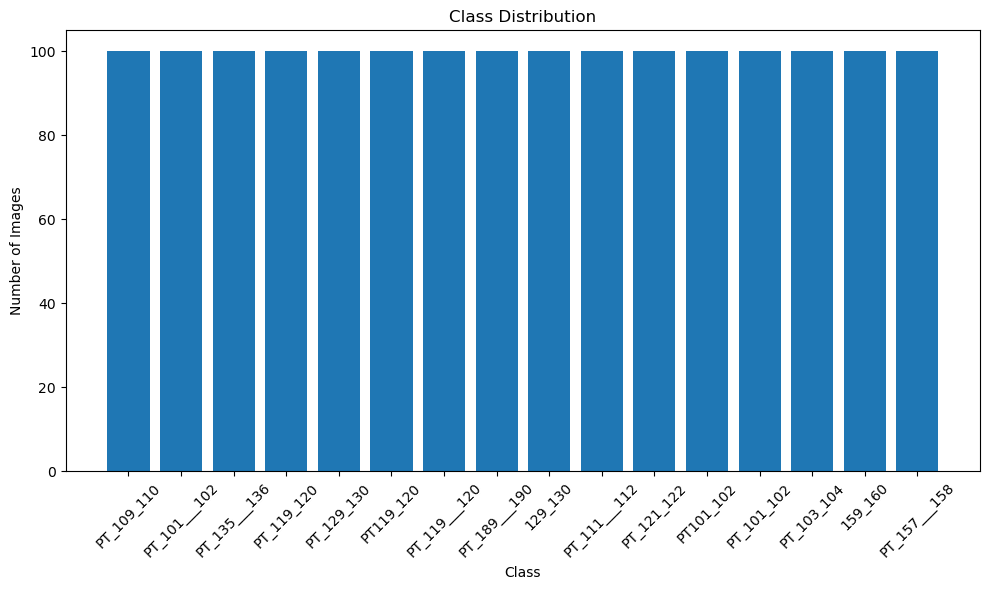


Visualizing preprocessing steps using /Users/anamikasaroha/Energy7_Week1/week_4/point_machine_images/PT_109_110/sample_953_PT-109_110.png


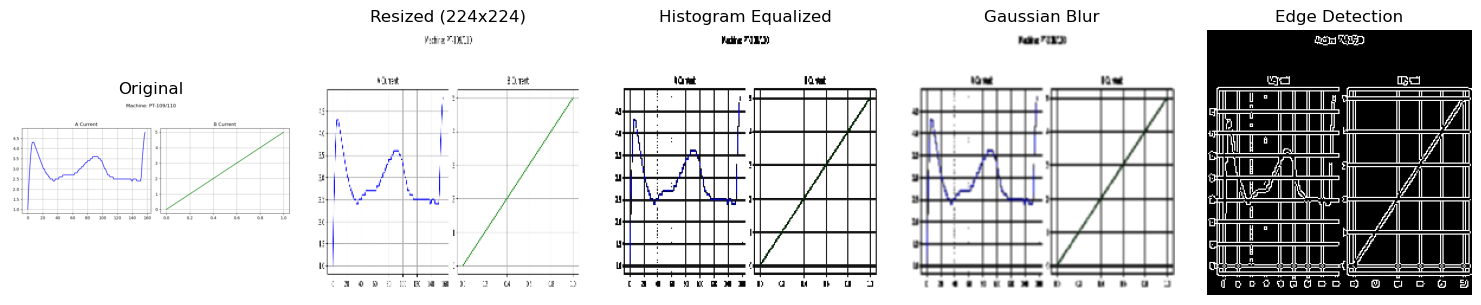


Preprocessing the dataset...
Processing 100 images in PT_109_110...


100%|██████████| 100/100 [00:00<00:00, 169.90it/s]


Processing 100 images in PT_101___102...


100%|██████████| 100/100 [00:00<00:00, 159.46it/s]


Processing 100 images in PT_135___136...


100%|██████████| 100/100 [00:00<00:00, 181.08it/s]


Processing 100 images in PT_119_120...


100%|██████████| 100/100 [00:00<00:00, 189.17it/s]


Processing 100 images in PT_129_130...


100%|██████████| 100/100 [00:00<00:00, 178.53it/s]


Processing 100 images in PT119_120...


100%|██████████| 100/100 [00:00<00:00, 161.28it/s]


Processing 100 images in PT_119___120...


100%|██████████| 100/100 [00:00<00:00, 178.83it/s]


Processing 100 images in PT_189___190...


100%|██████████| 100/100 [00:00<00:00, 184.67it/s]


Processing 100 images in 129_130...


100%|██████████| 100/100 [00:00<00:00, 184.08it/s]


Processing 100 images in PT_111___112...


100%|██████████| 100/100 [00:00<00:00, 188.27it/s]


Processing 100 images in PT_121_122...


100%|██████████| 100/100 [00:00<00:00, 172.81it/s]


Processing 100 images in PT101_102...


100%|██████████| 100/100 [00:00<00:00, 184.87it/s]


Processing 100 images in PT_101_102...


100%|██████████| 100/100 [00:00<00:00, 175.90it/s]


Processing 100 images in PT_103_104...


100%|██████████| 100/100 [00:00<00:00, 186.49it/s]


Processing 100 images in 159_160...


100%|██████████| 100/100 [00:00<00:00, 183.42it/s]


Processing 100 images in PT_157___158...


100%|██████████| 100/100 [00:00<00:00, 177.19it/s]


Preprocessing complete. Processed images saved to processed_images

Creating train/validation/test splits...

Dataset split complete:
  Train: 1120 images
    PT_109_110: 70 images
    PT_101___102: 70 images
    PT_135___136: 70 images
    PT_119_120: 70 images
    PT_129_130: 70 images
    PT119_120: 70 images
    PT_119___120: 70 images
    PT_189___190: 70 images
    129_130: 70 images
    PT_111___112: 70 images
    PT_121_122: 70 images
    PT101_102: 70 images
    PT_101_102: 70 images
    PT_103_104: 70 images
    159_160: 70 images
    PT_157___158: 70 images
  Validation: 240 images
    PT_109_110: 15 images
    PT_101___102: 15 images
    PT_135___136: 15 images
    PT_119_120: 15 images
    PT_129_130: 15 images
    PT119_120: 15 images
    PT_119___120: 15 images
    PT_189___190: 15 images
    129_130: 15 images
    PT_111___112: 15 images
    PT_121_122: 15 images
    PT101_102: 15 images
    PT_101_102: 15 images
    PT_103_104: 15 images
    159_160: 15 images
    PT_1

In [8]:
def main():
    ROOT_DIR = "/Users/anamikasaroha/Energy7_Week1/week_4/point_machine_images"
    
    # Analyze dataset
    print("Analyzing dataset...")
    analyze_dataset(ROOT_DIR)
    
    # Find a sample image for preprocessing visualization
    sample_image_path = None
    for class_name in os.listdir(ROOT_DIR):
        class_dir = os.path.join(ROOT_DIR, class_name)
        if os.path.isdir(class_dir):
            image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            if image_files:
                sample_image_path = os.path.join(class_dir, image_files[0])
                break
    
    if sample_image_path:
        print(f"\nVisualizing preprocessing steps using {sample_image_path}")
        visualize_preprocessing(sample_image_path)
    
    # Preprocess the dataset
    print("\nPreprocessing the dataset...")
    preprocess_dataset(ROOT_DIR)
    
    # Create train/val/test splits
    print("\nCreating train/validation/test splits...")
    create_train_val_test_split("processed_images")
    
    print("\nAll tasks completed!")

if __name__ == "__main__":
    main()